# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.

### ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.

---

**Tareas**:
1. Implementar la arquitectura de un Vision Transformer
2. Ingresar y ajustar los parámetros del modelo
3. Probar diferentes técnicas de data augmentation

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import math
import os
import time
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer


device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ', device)
print('Torch version: ', torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

Dispositivo:  cuda
Torch version:  2.6.0+cu124


# Transformer Encoder

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer

Variantes estandar de ViT:

| Layers | Hidden size (D) | MLP size | Heads | Params |
| ------ | --------------- | -------- | ----- | ------ |
| 12 | 768  | 3072 | 12 | 86M  |
| 24 | 1024 | 4096 | 16 | 307M |
| 32 | 1280 | 5120 | 16 | 632M |

In [11]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, ff_dim, num_layers,
                 num_classes=10, dropout=0.1, batch_first=True):
        super(VisionTransformer, self).__init__()

        # Patch embedding
        self.patch_embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim)

        # Positional encoding
        num_patches = (img_size//patch_size)**2
        self.positional_encoding = PositionalEncodingLearned(num_patches, embed_dim)

        # Transformer encoder
        self.transformer = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout, batch_first)

        # Normalization
        self.norm = nn.LayerNorm(embed_dim)

        # Classification
        self.ff = nn.Linear(embed_dim, num_classes)


    def forward(self, x):
        # Extract patches and embed them
        x = self.patch_embedding(x)  # Shape: (B, num_patches, embed_dim)

        # Add positional encoding
        x = self.positional_encoding(x)  # Shape: (B, num_patches, embed_dim)

        # Pass through transformer
        x = self.transformer(x)  # Shape: (B, num_patches, embed_dim)

        # Normalize and classify
        x = x[:, 0]  # Shape: (B, embed_dim)
        x = self.norm(x)
        x = self.ff(x)

        return x

# Dataset: CIFAR10

In [12]:
# Define transformations for the input data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [13]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"

folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

In [14]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,           # Tamaño de imagen (CIFAR-10 es 32x32)
    patch_size=8,          # Tamaño de cada parche
    embed_dim=64,          # Dimensión de los embeddings
    num_heads=4,           # Cabezas de atención
    ff_dim=256,            # Dimensión de la red feed-forward (4x embed_dim)
    num_layers=4,          # Capas Transformer
    dropout=0.1,           # Regularización
    batch_first=True       # Formato (batch, seq_len, embed_dim)
).to(device)

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

In [15]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
n_params = count_parameters(model)
print(f"Número de parámetros: {n_params:.2f} millones\n")

Número de parámetros: 0.21 millones



# Entrenamiento

In [16]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

start_time = time.time()
for epoch in range(num_epochs):
    trainer.train_model(use_amp=True)
    # scheduler.step()
training_time_seconds = time.time() - start_time
print(f"\nEntrenamiento finalizado en {training_time_seconds:.2f} segundos.")

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 1.36280: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]


Entrenamiento finalizado en 354.44 segundos.


# Evaluación

In [17]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    print(f"Evaluación:")
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print()
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print()

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

Evaluación:


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Accuracy: 0.5202
Precision: 0.5209
Recall: 0.5202
F1 score: 0.5149



# Visualización

## Visualización de las clasificaciones

  0%|          | 0/20 [00:00<?, ?it/s]


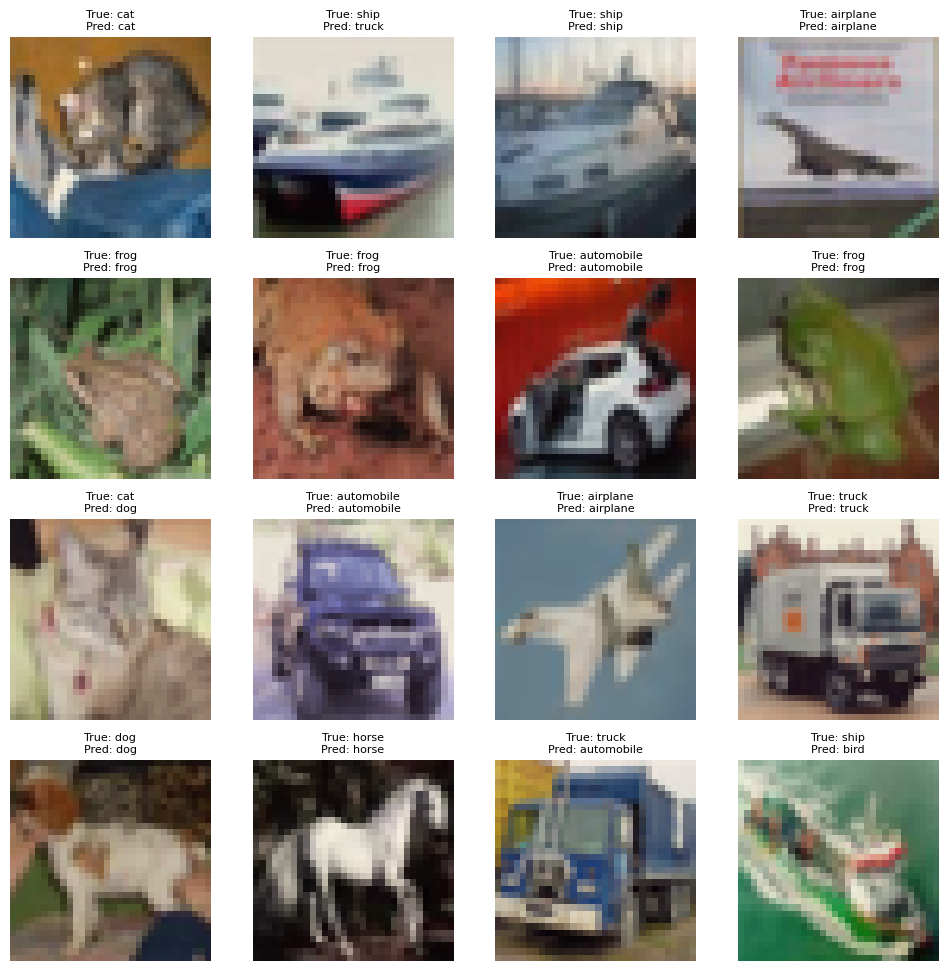

In [18]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}', fontsize=8)
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

## Visualización de las transformaciones

Sample 1:


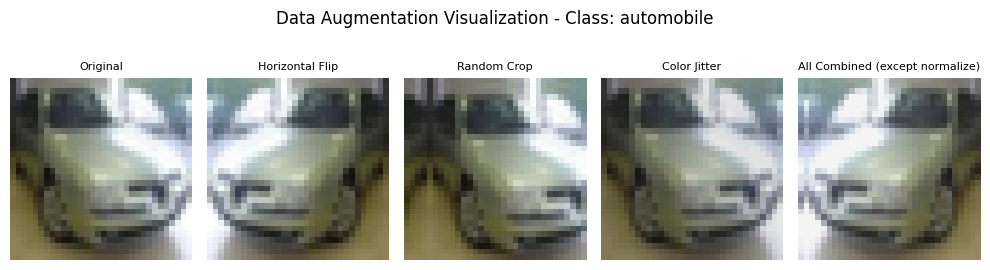

Sample 2:


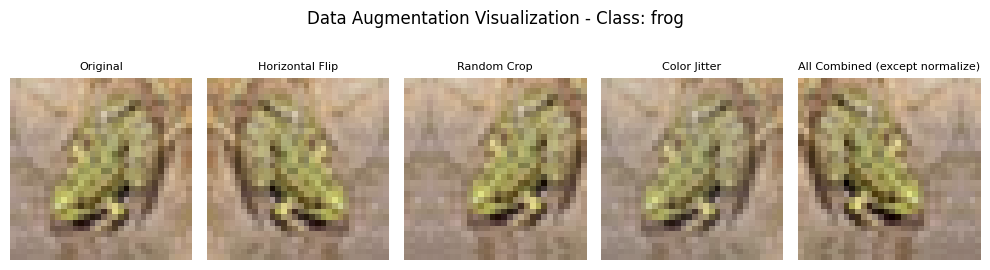

Sample 3:


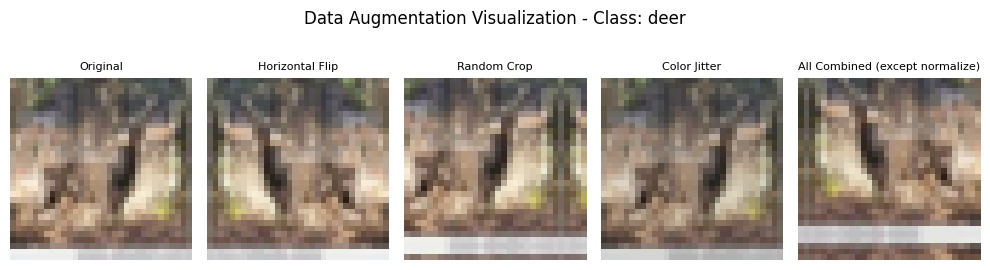

In [19]:
# Defino algunas transformaciones para visualizar
original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
original_loader = torch.utils.data.DataLoader(original_dataset, batch_size=5, shuffle=True)
images, labels = next(iter(original_loader))

transformations = {
    'Original': transforms.Compose([
        transforms.ToTensor()
    ]),
    'Horizontal Flip': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ]),
    'Random Crop': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.ToTensor()
    ]),
    'Color Jitter': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor()
    ]),
    'All Combined (except normalize)': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
    ])
}

# Clases CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_transforms(image, label, transformations):
    fig, axes = plt.subplots(1, len(transformations), figsize=(10, 3))
    fig.suptitle(f'Data Augmentation Visualization - Class: {class_names[label]}', fontsize=12)

    for i, (name, transform) in enumerate(transformations.items()):
        if name == 'Original':
            img_transformed = image
        else:
            img_transformed = transform(image)

        # Convert to numpy for display
        img_display = img_transformed.permute(1, 2, 0).numpy()

        # Clip values to valid range
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(name, fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Visualizamos las transformaciones para algunas imagenes
num_samples = 3
for i in range(num_samples):
    sample_image = images[i]
    sample_label = labels[i].item()
    print(f"Sample {i+1}:")
    visualize_transforms(sample_image, sample_label, transformations)

# Ajuste de parámetros del modelo

In [20]:
def run_experiment(name, patch_size, embed_dim, num_heads, num_layers):
    # Modelo
    model = VisionTransformer(
        img_size=32,           # Tamaño de imagen (CIFAR-10 es 32x32)
        patch_size=patch_size, # Tamaño de cada parche
        embed_dim=embed_dim,   # Dimensión de los embeddings
        num_heads=num_heads,   # Cabezas de atención
        ff_dim=embed_dim*4,    # Dimensión de la red feed-forward (4x embed_dim)
        num_layers=num_layers, # Capas Transformer
        dropout=0.1,           # Regularización
        batch_first=True       # Formato (batch, seq_len, embed_dim)
    ).to(device)

    print(f"Configuración:\n patch_size: {patch_size}\n embed_dim: {embed_dim}\n num_heads: {num_heads}\n num_layers: {num_layers}\n")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
    model = model.to(device)
    model = torch.compile(model)
    torch.cuda.empty_cache()
    n_params = count_parameters(model)
    print(f"Número de parámetros: {n_params:.2f} millones\n")

    # Entrenamiento
    print(f"Entrenamiento:")
    trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
    start_time = time.time()
    for epoch in range(num_epochs):
        trainer.train_model(use_amp=True)
    training_time_seconds = time.time() - start_time
    print(f"Entrenamiento finalizado en {training_time_seconds:.2f} segundos\n")

    # Evaluacion
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

    print("***************************")

    # Retornar los resultados
    return {
        "name": name,
        "patch_size": patch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "n_params": n_params,
        "training_time_s": round(training_time_seconds, 2),
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4)
    }

In [21]:
# Valores iniciales
patch_size = 8
embed_dim = 64
num_heads = 4
num_layers = 4
results_v0 = run_experiment("inicial", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 8
 embed_dim: 64
 num_heads: 4
 num_layers: 4

Número de parámetros: 0.21 millones

Entrenamiento:


loss 1.25217: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]


Entrenamiento finalizado en 347.54 segundos

Evaluación:


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Accuracy: 0.5363
Precision: 0.5320
Recall: 0.5363
F1 score: 0.5323

***************************


In [22]:
#@title 1) Más capas
patch_size = 8
embed_dim = 64
num_heads = 4
num_layers = 8
results_v1 = run_experiment("más capas", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 8
 embed_dim: 64
 num_heads: 4
 num_layers: 8

Número de parámetros: 0.41 millones

Entrenamiento:


loss 1.31062: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]


Entrenamiento finalizado en 350.51 segundos

Evaluación:


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Accuracy: 0.5331
Precision: 0.5290
Recall: 0.5331
F1 score: 0.5281

***************************


In [23]:
#@title 2) Mayor dimensión de embeddings
patch_size = 8
embed_dim = 128
num_heads = 4
num_layers = 4
results_v2 = run_experiment("mayor embed dim", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 8
 embed_dim: 128
 num_heads: 4
 num_layers: 4

Número de parámetros: 0.82 millones

Entrenamiento:


loss 1.18686: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Entrenamiento finalizado en 346.16 segundos

Evaluación:


100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


Accuracy: 0.5573
Precision: 0.5644
Recall: 0.5573
F1 score: 0.5489

***************************


In [24]:
#@title 3) Mayor cantidad de cabezas de atención
patch_size = 8
embed_dim = 64
num_heads = 8
num_layers = 4
results_v3 = run_experiment("más heads", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 8
 embed_dim: 64
 num_heads: 8
 num_layers: 4

Número de parámetros: 0.21 millones

Entrenamiento:


loss 1.41459: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]


Entrenamiento finalizado en 343.72 segundos

Evaluación:


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Accuracy: 0.5266
Precision: 0.5202
Recall: 0.5266
F1 score: 0.5184

***************************


In [30]:
#@title 4) Menor patch size
patch_size = 4
embed_dim = 64
num_heads = 4
num_layers = 4
results_v4 = run_experiment("menor patch size", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 4
 embed_dim: 64
 num_heads: 4
 num_layers: 4

Número de parámetros: 0.21 millones

Entrenamiento:


loss 1.40533: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s]


Entrenamiento finalizado en 651.62 segundos

Evaluación:


100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Accuracy: 0.4953
Precision: 0.4940
Recall: 0.4953
F1 score: 0.4826

***************************


# Pruebas con otras transformaciones de data augmentation

In [26]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0, inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

patch_size = 8
embed_dim = 128
num_heads = 4
num_layers = 4
results_v5 = run_experiment("v2 con data aug", patch_size=patch_size, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

Configuración:
 patch_size: 8
 embed_dim: 128
 num_heads: 4
 num_layers: 4

Número de parámetros: 0.82 millones

Entrenamiento:


loss 1.33153: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]


Entrenamiento finalizado en 598.65 segundos

Evaluación:


100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


Accuracy: 0.5469
Precision: 0.5470
Recall: 0.5469
F1 score: 0.5431

***************************


# Resultados

In [31]:
results = [results_v0, results_v1, results_v2, results_v3, results_v4, results_v5]
df_results = pd.DataFrame(results)
df_results = df_results.set_index('name')
display(df_results)

,patch_size,embed_dim,num_heads,num_layers,n_params,training_time_s,accuracy,precision,recall,f1_score
name,,,,,,,,,,
inicial,8,64,4,4,0.214090,347.54,0.5363,0.5320,0.5363,0.5323
más capas,8,64,4,8,0.414026,350.51,0.5331,0.5290,0.5331,0.5281
mayor embed dim,8,128,4,4,0.821386,346.16,0.5573,0.5644,0.5573,0.5489
más heads,8,64,8,4,0.214090,343.72,0.5266,0.5202,0.5266,0.5184
menor patch size,4,64,4,4,0.207946,651.62,0.4953,0.4940,0.4953,0.4826
v2 con data aug,8,128,4,4,0.821386,598.65,0.5469,0.5470,0.5469,0.5431


# Conclusiones
- La mejor accuracy (55%) es un buen primer paso para un ViT chico (0.8M parámetros) entrenado desde cero en CIFAR-10 con entrenamiento limitado (10 épocas). 
- En los experimentos realizados aumentar la dimensión de los embeddings fue el cambio más beneficioso, logrando la mejor accuracy y f1_score sin un costo excesivo en tiempo de entrenamiento.
- Aumentar la cantidad de capas y de cabezas de atención no mejoró el rendimiento.
- Reducir el patch size a 4 fue contraproducente, tanto en métricas como en tiempo de entrenamiento.
- Las transformaciones nuevas que se usaron data augmentation no mejoraron los resultados de la mejor configuración y aumentó el tiempo de entrenamiento.

# Trabajo futuro
- Experimentar con modelos más grandes.
- Experimentar con más épocas de entrenamiento.
- Realizar una búsqueda exhaustiva de hiperparámetros.
- Experimentar con otras técnicas y combinaciones de data augmentation.